In [1]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import rasterio
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Load the training labels with coordinates
training_data = pd.read_csv('training_labels_with_coordinates.csv')

# Load PCA and LST rasters
pca_raster = rasterio.open('pca_raster.tif') 
lst_raster = rasterio.open('lst_raster.tif') 

# Function to extract raster values for given coordinates
def extract_raster_values(raster, coords):
    values = []
    for x, y in coords:
        row, col = raster.index(x, y)  # Convert coordinates to raster row, col
        values.append(raster.read(1)[row, col])  # Read raster value at the location
    return np.array(values)

# Extract raster values for PCA components
coords = list(zip(training_data['X'], training_data['Y']))
pca_values = np.stack([extract_raster_values(pca_raster, coords) for _ in range(pca_raster.count)]).T

# Extract raster values for LST
lst_values = extract_raster_values(lst_raster, coords)

# Combine PCA and LST values into a feature matrix
features = np.hstack((pca_values, lst_values.reshape(-1, 1)))

# Convert classes to numerical labels if needed
labels = training_data['Class'].values

# Normalize features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.15, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.75      0.30      0.43        10
           2       0.60      0.90      0.72        10
           3       0.86      0.86      0.86         7

    accuracy                           0.75        36
   macro avg       0.78      0.76      0.74        36
weighted avg       0.77      0.75      0.72        36



In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],       # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']    # Kernel types
}

# Initialize the SVM model
svm = SVC()

# Perform grid search
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(features_normalized, labels)

# Display the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Retrieve the best model
best_svm_model = grid_search.best_estimator_


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'poly'}
Best Score: 0.85


In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.15, random_state=42)

# Train the SVM model
svm_model = SVC(kernel='poly', C=0.1, gamma=1)
svm_model.fit(X_train, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       0.89      0.80      0.84        10
           2       0.82      0.90      0.86        10
           3       1.00      0.86      0.92         7

    accuracy                           0.89        36
   macro avg       0.90      0.89      0.89        36
weighted avg       0.89      0.89      0.89        36



In [9]:
from rasterio.enums import Resampling

# Read PCA raster data
pca_data = pca_raster.read()  # All PCA bands
rows, cols = pca_raster.height, pca_raster.width

# Resample LST raster to match PCA raster dimensions
with rasterio.open('lst_raster.tif') as src:
    lst_data_resampled = src.read(
        out_shape=(
            src.count,
            rows,
            cols
        ),
        resampling=Resampling.bilinear
    )[0]  # Read the first (and only) band

# Flatten raster data
flat_pca = pca_data.reshape(pca_raster.count, -1).T  # PCA bands stacked as features
flat_lst = lst_data_resampled.flatten()  # Flatten the resampled LST raster

# Combine PCA and LST into a feature matrix
features = np.hstack((flat_pca, flat_lst.reshape(-1, 1)))

# Normalize features using the same scaler used during training
features_normalized = scaler.transform(features)

# Predict the classes for all pixels
predicted_classes = svm_model.predict(features_normalized)

# Reshape the predictions to match the raster dimensions
predicted_raster = predicted_classes.reshape(rows, cols)

# Convert predicted raster
predicted_raster = predicted_raster.astype('int32')

# Save the predicted raster as GeoTIFF with the correct data type
with rasterio.open(
    'predicted_raster_svm.tif', 'w',
    driver='GTiff',
    height=rows,
    width=cols,
    count=1,
    dtype='int32',
    crs=pca_raster.crs,
    transform=pca_raster.transform
) as dst:
    dst.write(predicted_raster, 1)

print("Predicted raster saved as 'predicted_raster_svm.tif'.")


Predicted raster saved as 'predicted_raster_svm.tif'.


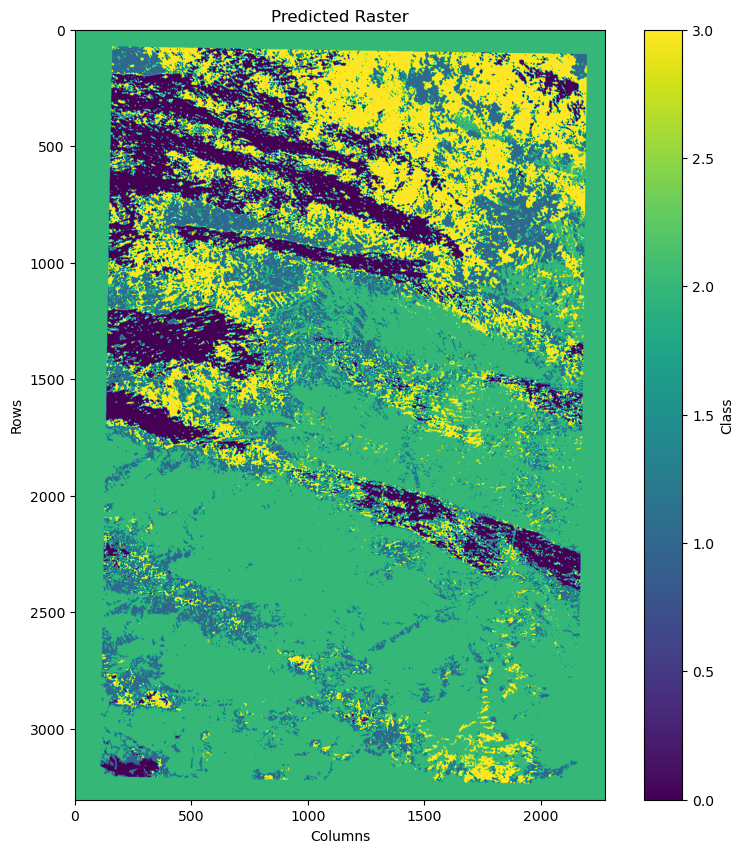

In [11]:
import matplotlib.pyplot as plt

# Plot the predicted raster
plt.figure(figsize=(10, 10))
plt.imshow(predicted_raster, cmap='viridis')
plt.colorbar(label='Class')
plt.title('Predicted Raster')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()
